In [35]:
!git clone https://github.com/mykola-mmm/airbus_kaggel.git


Cloning into 'airbus_kaggel'...
remote: Enumerating objects: 219, done.
remote: Counting objects: 100% (64/64), done.
remote: Compressing objects: 100% (30/30), done.
remote: Total 219 (delta 36), reused 62 (delta 34), pack-reused 155
Receiving objects: 100% (219/219), 141.89 MiB | 22.97 MiB/s, done.
Resolving deltas: 100% (105/105), done.


In [36]:
import os
os.chdir('./airbus_kaggel')

In [37]:
!git checkout v2

Branch 'v2' set up to track remote branch 'v2' from 'origin'.
Switched to a new branch 'v2'


In [38]:
!python --version

Python 3.10.13


To show 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 358ms/step
prediction shape - (1, 256, 256, 1)


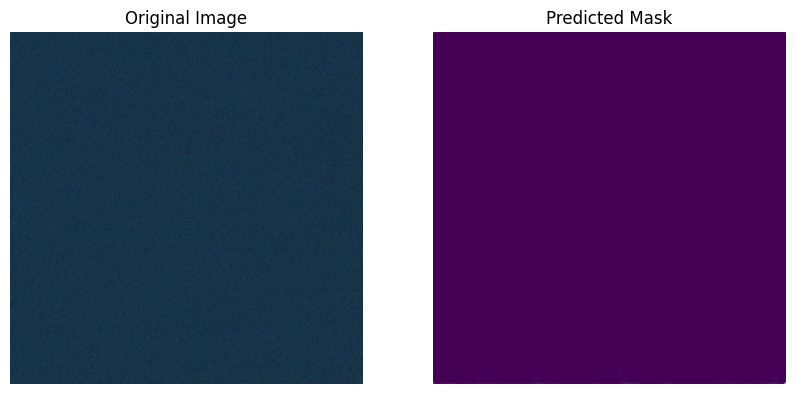

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
prediction shape - (1, 256, 256, 1)


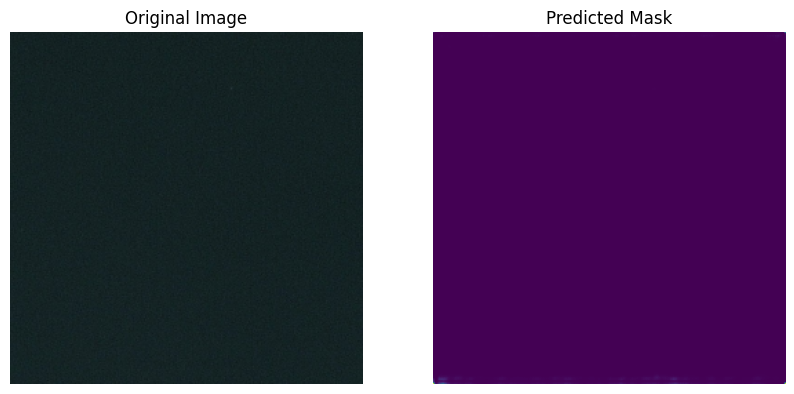

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
prediction shape - (1, 256, 256, 1)


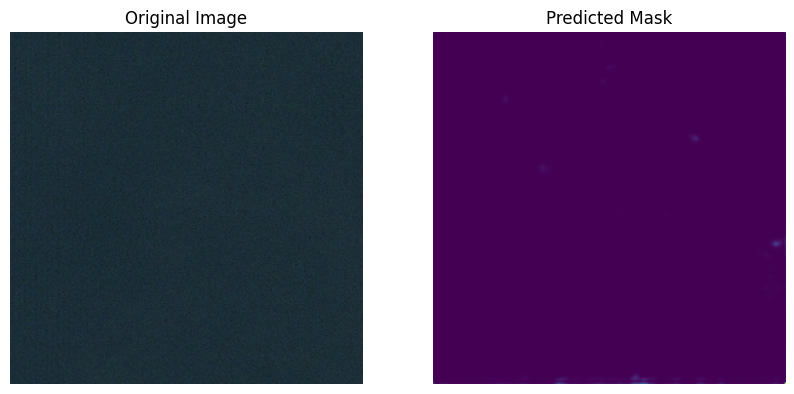

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
prediction shape - (1, 256, 256, 1)


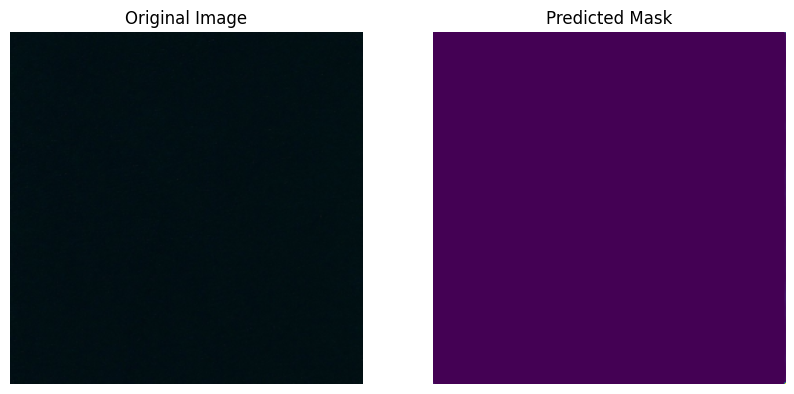

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
prediction shape - (1, 256, 256, 1)


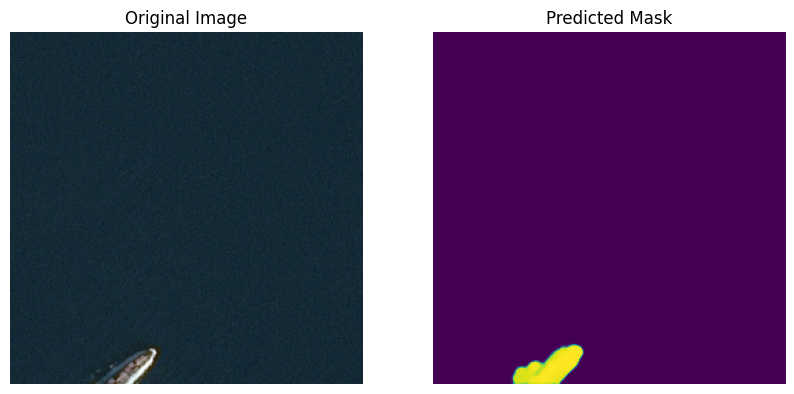

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
prediction shape - (1, 256, 256, 1)


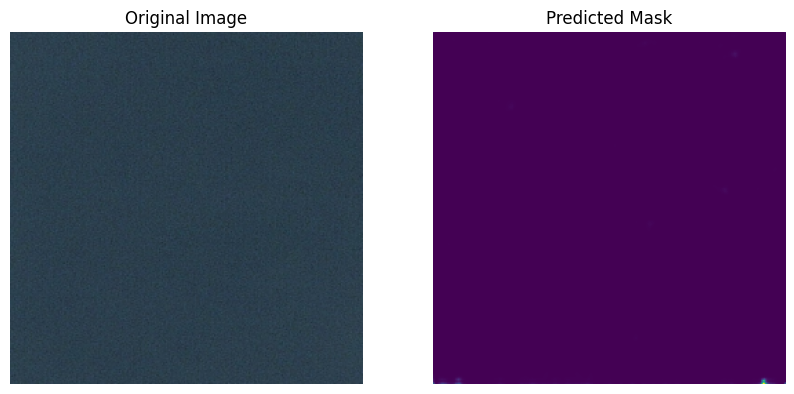

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
prediction shape - (1, 256, 256, 1)


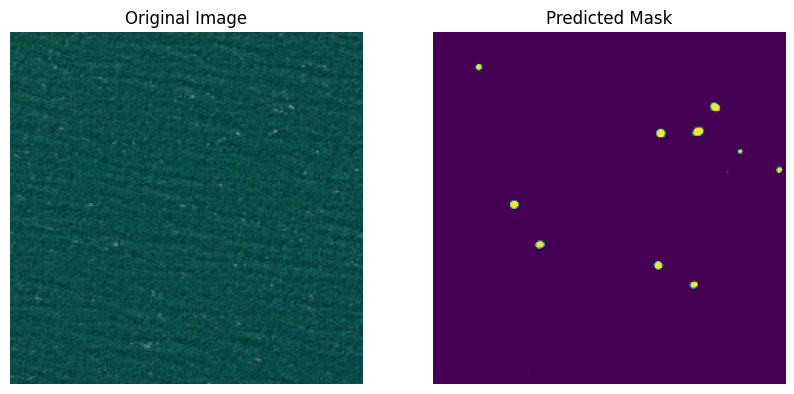

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
prediction shape - (1, 256, 256, 1)


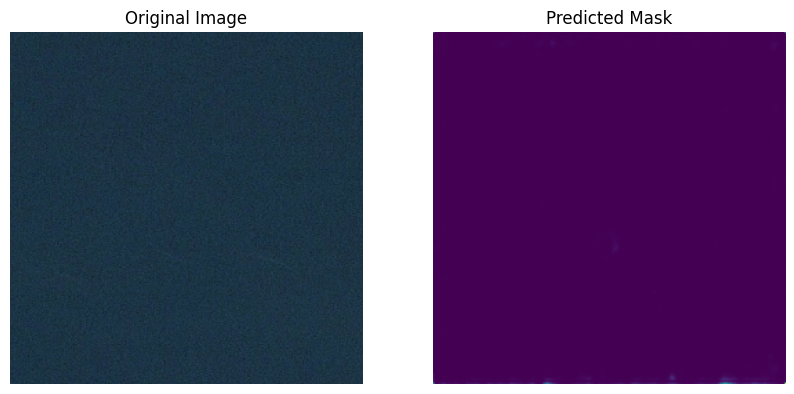

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
prediction shape - (1, 256, 256, 1)


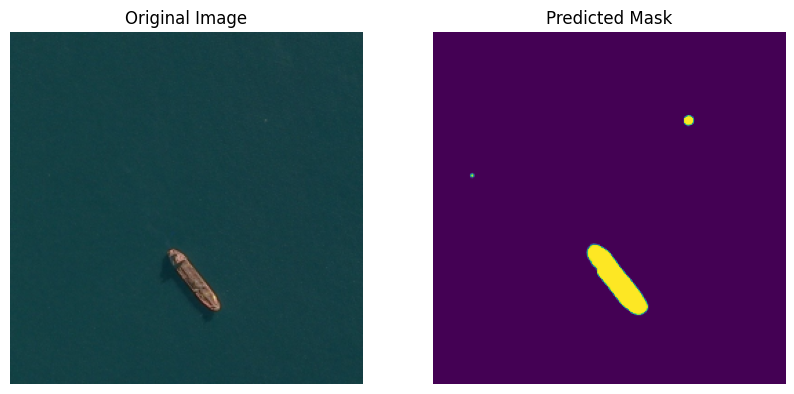

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
prediction shape - (1, 256, 256, 1)


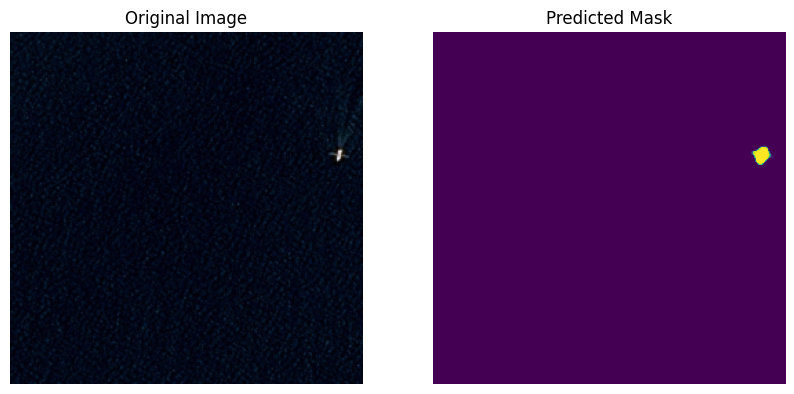

<Figure size 640x480 with 0 Axes>

In [41]:
%run  ./test-model.py --model_path ./models/model_256x256.epoch71-val_dice_score0.650.keras --num_test_images=10 --test_data_path /kaggle/input/airbus-ship-detection/test_v2 --patch_size=256